In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import xlrd
import operator
import math
import re
import nltk
import scipy
from tempfile import mkdtemp
from shutil import rmtree
import openpyxl
from pactools.grid_search import GridSearchCVProgressBar
from collections import Counter, defaultdict
from itertools import chain, product
from decimal import Decimal
from ast import literal_eval
from tqdm import tqdm


# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pd.options.mode.chained_assignment = None

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [2]:
# Importing data
def importdata(file):
    df = pd.read_csv(file, index_col=0)
    df = df.loc[df['speech category'] == 'Main Speech']
    return df 
df = importdata("HandelingenRutte2.csv")
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t.lower() for t in tokenizer.tokenize(x)]))
df.drop(columns=['tags'])
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


# Data Info

803.9600230083405 444.0


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


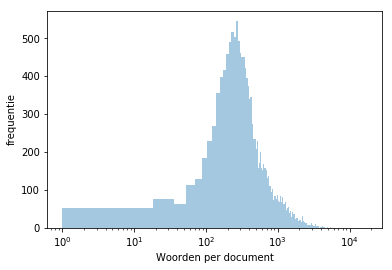

In [3]:
#leaving out all that is outside 95%
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
t = [len(doc) for doc in list_text]
print(np.mean(t),np.median(t))
fit =scipy.stats.lognorm.fit(t)
ax = sns.distplot(t,bins=1000,norm_hist=False,kde=False)
ax.set_xscale('log')
ax.set(xlabel='Woorden per document', ylabel='frequentie')
plt.savefig("Verslag/Tables/lengthtextslog.png")

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


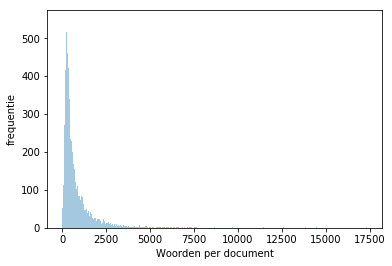

In [4]:
ax = sns.distplot(t, bins=1000, norm_hist=False,kde=False)
ax.set(xlabel='Woorden per document', ylabel='frequentie')
plt.savefig("Verslag/Tables/lengthtexts.png")

In [5]:
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
print("Ondergrens:",math.exp(fit[0]+2*fit[1]),"\nBovengrens:",math.exp(fit[0]-2*fit[1]))
print("Mediaan",np.median([len(doc) for doc in list_text]),"\nGemiddelde",np.mean([len(doc) for doc in list_text]))
print("Overgebleven documenten:",len(df))

Ondergrens: 1492.675589876518 
Bovengrens: 27.339307082607387
Mediaan 386.0 
Gemiddelde 498.18961004094234
Overgebleven documenten: 14899


In [6]:
len(df.file.unique())

2984

In [7]:
#https://stackoverflow.com/questions/11350770/pandas-dataframe-select-by-partial-string

# Creates a dataframe with counts of dataset per party
countdf = pd.concat([df.party.value_counts(),df[df['titel'].str.contains("Vragen van het lid")].party.value_counts(), df[~df['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdf.columns = ['Totaal', 'Vragenuur','Debat']
countdf = countdf.sort_values("Totaal",axis=0, ascending=False)
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=True))
countdf = countdf.sort_index()
countdf

,Totaal,Vragenuur,Debat
50PLUS,387,12,375
CDA,1901,88,1813
ChristenUnie,1068,32,1036
D66,1889,133,1756
GroenLinks,1068,47,1021
PVV,1700,49,1651
PvdA,1821,112,1709
PvdD,432,14,418
SGP,655,10,645
SP,2284,107,2177


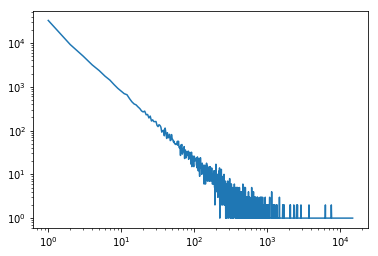

In [8]:
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
del list_text
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

# Baseline

In [9]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf["Totaal"].sum() for x in list(countdf['Totaal'])])
print(classification_report(df.party, simpleprediction))
print("Accuracy:",accuracy_score(df.party, np.full(len(df.party), countdf["Totaal"].idxmax())))

              precision    recall  f1-score   support

      50PLUS       0.02      0.02      0.02       387
         CDA       0.12      0.12      0.12      1901
ChristenUnie       0.07      0.07      0.07      1068
         D66       0.12      0.11      0.11      1889
  GroenLinks       0.08      0.08      0.08      1068
         PVV       0.11      0.11      0.11      1700
        PvdA       0.12      0.12      0.12      1821
        PvdD       0.03      0.03      0.03       432
         SGP       0.05      0.05      0.05       655
          SP       0.15      0.15      0.15      2284
         VVD       0.11      0.11      0.11      1694

 avg / total       0.11      0.11      0.11     14899

Accuracy: 0.15329887911940399


# Models

In [10]:
def modelsdownload(file,only_doen=False):
    models_df = pd.read_excel(file, index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [ ]:
models_df, models_dict = modelsdownload('Models.xlsx',True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}


In [ ]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    print("Bezig: %s" %name)
    if text_dict[name]:
         text = df.stemmed_text
    else:
        text = df.normal_text
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=-1)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name 
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_excel('Scores.xlsx', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_excel('Scores.xlsx')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [11]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

In [12]:
# https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
def classifaction_report_csv(report,save):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['Partij'] = row_data[-5]
        row['Precision'] = float(row_data[-4])
        row['Recall'] = float(row_data[-3])
        row['F1_score'] = float(row_data[-2])
        row['Documenten'] = int(row_data[-1])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe = dataframe.reindex(["Partij","Precision","Recall","F1_score","Documenten"], axis=1)

    return dataframe.set_index('Partij')

In [13]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_excel(file, index_col=0).sort_values(['mean_test_f1_weighted'], ascending=False).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload('Models.xlsx',False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:16<00:00, 94.25s/it]


              Precision  Recall  F1_score  Documenten
Partij                                               
50PLUS            0.902   0.904     0.904        75.8
   CDA            0.786   0.768     0.774       384.4
ChristenUnie      0.852   0.744     0.794       218.0
   D66            0.760   0.706     0.730       372.8
  GroenLinks      0.858   0.734     0.790       216.8
   PVV            0.726   0.846     0.780       347.6
  PvdA            0.706   0.632     0.666       356.2
  PvdD            0.854   0.866     0.858        88.8
   SGP            0.710   0.832     0.762       128.4
    SP            0.734   0.794     0.762       453.4
   VVD            0.696   0.694     0.694       337.8


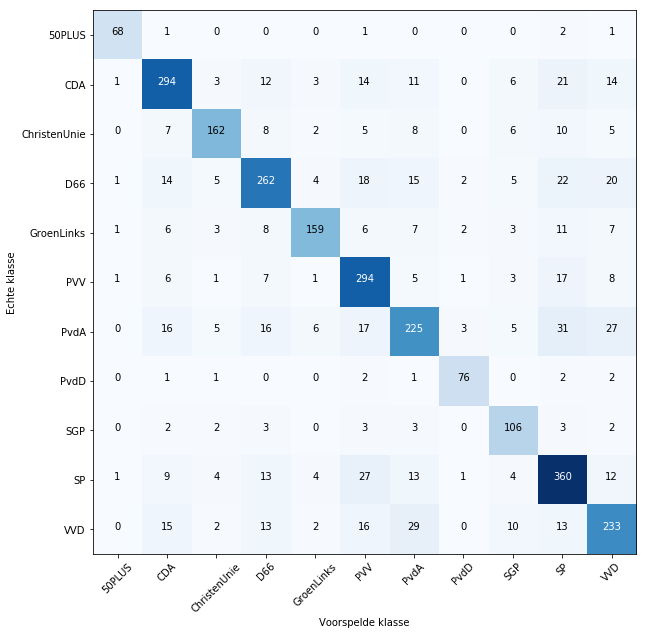

[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=1,
        vocabulary=None)), ('SGD', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5.0, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]


In [14]:
def traintest3(file, data, save=False):
    train, test = datasplitter(data, 0.8)
    pipe, stem = getbestpipe(file)
    if stem:
        pipe.fit(train.stemmed_text, train.party)
        predicted = pipe.predict(test.stemmed_text)
    else:
        pipe.fit(train.normal_text,train.party)
        predicted = pipe.predict(test.normal_text)
    report = classifaction_report_csv(classification_report(test.party, predicted),False)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    return pipe, cnf_matrix, report, accuracy
    

def traintest(file, data, save=False):
    pipe, cnf_matrix, report, accuracy = traintest3(file, data, save=False)
    for x in tqdm(range(4)):
        _, cnf_matrix2, report2, accuracy2 = traintest3(file, data, save=False)
        cnf_matrix = np.add(cnf_matrix,cnf_matrix2)
        report = report.add(report2, fill_value=0)
        accuracy += accuracy2
    accuracy /=5
    cnf_matrix = np.divide(cnf_matrix,5)
    report /=5
     
    print(report)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(data.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())

    plt.show()
    return pipe

def datasplitter(dataframe, frac):
    df_train = dataframe.sample(frac=frac)
    df_test_index = list(set(dataframe.index.tolist()) - set(df_train.index.tolist()))
    df_test = dataframe[dataframe.index.isin(df_test_index)]
    return df_train, df_test

pipe = traintest('Scores.xlsx', df,save="confusionmatrix")
print(pipe.steps)

In [15]:
def mostimportantwords(pipe, countdf, filename):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = [[inv_vocab[t] for t in coefs[i].argsort()[-10:][::-1]] for i in range(coefs.shape[0])]
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    with open("Verslag/Tables/%s1.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,:5].to_latex(index=False))
    with open("Verslag/Tables/%s2.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,5:].to_latex(index=False))
    return top_words

mostimportantwords(pipe, countdf, 'MostImportantWords')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,de christenunie,d66,groenlink,pvv,de pvda,lid ouwehand nar,sgp,sp,de vvd
1,het lid krol,het cda,christenunie,led van veldhov,lid van tonger,de pvv,pvda,lid ouwehand,de sgp,de sp,vvd
2,lid krol,cda fractie,lid dik faber,lid van veldhov,lid voortman nar,islamitisch,pvda fractie,het lid ouwehand,sgp fractie,lid van gerv,de vvd is
3,lid krol nar,de cda fractie,lid dik,lid van men,lid voortman,lid graus,de pvda fractie,ouwehand nar mij,de sgp fractie,gerv nar mij,vvd is
4,krol nar mij,de cda,het lid dik,d66 is,het lid voortman,het lid graus,van de arbeid,ouwehand nar,led van der,gerv nar,de vvd fractie
5,krol nar,lid omtzigt nar,de led dik,d66 wil,led van tonger,lid graus nar,de partij van,ouwehand,led dijkgraf,van gerv nar,vvd fractie
6,van 50plus,lid omtzigt,led dik,led van men,tonger nar mij,graus nar,de arbeid,vor de dier,de led dijkgraf,sp fractie,vor de vvd
7,krol,het lid omtzigt,led dik faber,van veldhov,tonger nar,graus nar mij,partij van de,de dier,sgp is,de sp fractie,wat de vvd
8,gepensioneerd,cda is,de led voordewind,veldhov,van tonger nar,miljard,partij van,dier,de sgp is,leijt nar,vvd betreft
9,fractie van 50plus,het cda is,led voordewind,led schouw,van tonger,graf,de arbeid is,thiem,de led bisschop,leijt nar mij,de vvd betreft


# Without Names

In [16]:
df = importdata("HandelingenRutte2.csv")
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
df['text'] = df.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower().replace("xxxxx",'KAMERlIDNAAM').replace("yyyyy", 'PARTIJNAAM'))
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t for t in tokenizer.tokenize(x)]))
df.drop(columns=['text', 'tags','titel','file'])
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n voorzitter. vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n voorzitter. tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n voorzitter. al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n voorzitter. we...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [12:17<00:00, 184.39s/it]


              Precision  Recall  F1_score  Documenten
Partij                                               
50PLUS            0.676   0.408     0.496        81.4
   CDA            0.560   0.322     0.400       435.2
ChristenUnie      0.586   0.234     0.312       245.0
   D66            0.482   0.574     0.500       435.6
  GroenLinks      0.552   0.222     0.308       237.0
   PVV            0.506   0.776     0.608       364.8
  PvdA            0.578   0.328     0.398       468.0
  PvdD            0.660   0.592     0.602       101.0
   SGP            0.540   0.664     0.554       153.4
    SP            0.530   0.560     0.536       520.0
   VVD            0.464   0.610     0.506       435.6


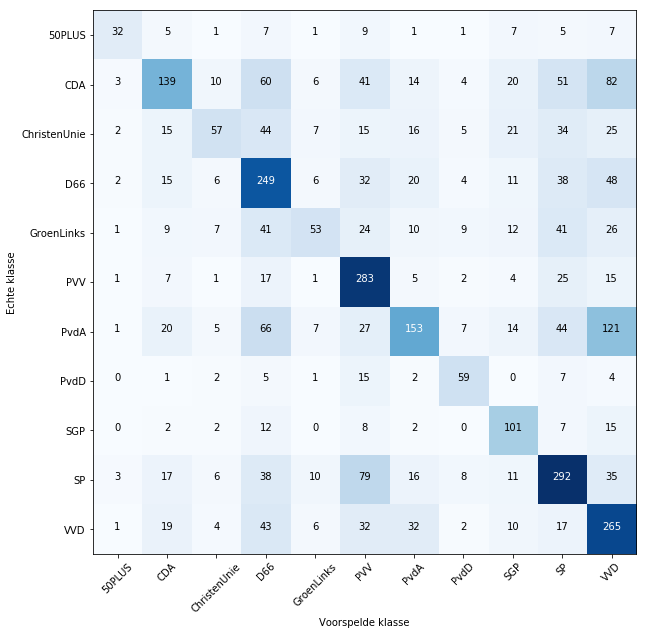

In [17]:
pipe = traintest('Scores.xlsx', df, save="withoutnames")

In [18]:
mostimportantwords(pipe, countdf, 'MostImportantWordsWithoutNames')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50 plusser,inwoner,voedselverspill,mijn fractie,schon energie,islamitisch,mijn partij,bio industrie,mevrouw de voorzitter,segregatie,volgen mij
1,gepensioneerd,partijnam fractie,koerd,buitengewon,banenplan,islam,ieder kind,de bio industrie,mevrouw de,de bevolk,liberal
2,plusser,hier,inderdad,daarom,belastingontwijk,brussel,leerkracht,de bio,allerlei,herindel,essentieel
3,koopkrachtontwikkel,middeninkomen,rookvrij,natur,huishoud zorg,de islam,hulpverlener,dier,eenverdiener,zegt,regelgev
4,exact,diver,rechtsstat,hervorm,kamer hierover te,asielzoeker,open standaard,bio,punt,ouderbijdrag,dit land
5,50,echt,gezinn,vandag,voorzitter motie,miljard,lager over,aan de bio,vanuit,bureaucratie,partijnam fractie
6,ouder,nederland spoorweg,godsdienstvrij,kans,voorzitter motie de,nederland,al eerder,de natur,allereerst,huurder,speelveld
7,ouderenwerklos,spoorweg,ik constater,belangrijk,democratisch,dit kabinet,gezamen,industrie,nadruk,armoed,partijnam is
8,de 50 plusser,onz fractie,loonwaard,unido,schon,immigratie,beter,bestrijdingsmiddel,oog,amen,daadwerk
9,werkend,de nederland spoorweg,locaties,dadelijk,zou,verzorgingshuiz,sam,klimaatverander,wel,bevolk,op ord


# Confusion matrix analyse

In [19]:
def traintest2(file, data, save=False):
    train, test = data
    pipe, stem = getbestpipe(file)
    if stem:
        pipe.fit(train.stemmed_text, train.party)
        predicted = pipe.predict(test.stemmed_text)
    else:
        pipe.fit(train.normal_text,train.party)
        predicted = pipe.predict(test.normal_text)
    cm = confusion_matrix(test.party, predicted)
    tot = len(predicted)
    ggg = defaultdict(int)
    mix = []
    regering = []
    oppositie = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[0]):
            if i!=j:
                a = (sum(cm[i,:])-cm[i,i]) * (sum(cm[j,:])/(tot-sum(cm[i,:])))
                ggg[(i,sum(cm[i,:]))]+=a
                if i in [6,10] and j in [6,10]:
                    regering.append(cm[i,j]-a)
                elif i in [0,1,2,3,4,5,7,8,9] and j in [0,1,2,3,4,5,7,8,9]:
                    oppositie.append(cm[i,j]-a)
                else:
                    mix.append(cm[i,j]-a)

    return pipe, oppositie, regering, mix, ggg

In [ ]:
o = []
m = []
r = []
g = {}
for i in tqdm(range(10)):
    pipe, oppositie, regering, mix, ggg=traintest2('Scores.xlsx', datasplitter(df, 0.8))
    g ={**g, **ggg}
    o.append(oppositie)
    r.append(regering)
    m.append(mix)

 20%|████████████████▍                                                                 | 2/10 [06:08<24:33, 184.21s/it]

In [ ]:
(keys,values) = zip(*g.items())
party, keys = zip(*keys)
keys = pd.Series(keys,name="Documenten behorende tot partij x in test set")
values = pd.Series(values,name="Foutief als partij geclassificeerde documenten")
party = pd.Series(party,name="Partij").replace(dict(enumerate(sorted(df.party.unique()))))
q = sns.lmplot(x='fn + tp', y='fp', hue='Partij', data=pd.concat([keys, values, party], axis=1),fit_reg=False, palette=sns.color_palette("hls", 11))
ax = sns.regplot(keys, values, scatter=False, ax=q.axes[0, 0])
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Correlation.png') 
scipy.stats.pearsonr(keys,values)

In [ ]:
# Dit gebruiken
ax = sns.distplot(list(chain.from_iterable(o)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Oppositie.png') 
print("Mean:",np.mean(list(chain.from_iterable(o))))
print(scipy.stats.normaltest(list(chain.from_iterable(o))))

In [ ]:
ax = sns.distplot(list(chain.from_iterable(r)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Regering.png') 
np.mean(list(chain.from_iterable(r)))

In [ ]:
ax = sns.distplot(list(chain.from_iterable(m)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Mix.png') 
np.mean(list(chain.from_iterable(m)))

In [ ]:
ax = sns.distplot(list(chain.from_iterable(m+o+r)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Totaal.png')
print(np.mean(list(chain.from_iterable(m+o+r))))
print(scipy.stats.normaltest(list(chain.from_iterable(m+o+r))))

In [ ]:
scipy.stats.normaltest(list(chain.from_iterable(m+o+r)))

# Regering & Oppositie

In [ ]:
df['PartijStatus'] = df['party'].map({'CDA': 'Oppositie', 'ChristenUnie': 'Oppositie', 'D66':'Oppositie', 'SGP':'Oppositie', 'VVD':'Regering', 'SP':'Oppositie','PvdD':'Oppositie','GroenLinks':'Oppositie','PvdA':'Regering','50PLUS':'Oppositie'})
pipe = traintest('Scores.xlsx', datasplitter(df.dropna(), 0.8))

In [ ]:
# regering
vocab = pipe.named_steps['vect'].vocabulary_
inv_vocab = {v: k for k, v in vocab.items()}
coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
top_words = []
for i in range(coefs.shape[0]):
    temp_list = []
    for t in coefs[i].argsort()[-10:][::-1]:
        temp_list.append(inv_vocab[t])
    top_words.append(temp_list)
top_words = pd.DataFrame(top_words).T
top_words

In [ ]:
# oppositie
vocab = pipe.named_steps['vect'].vocabulary_
inv_vocab = {v: k for k, v in vocab.items()}
coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
top_words = []
for i in range(coefs.shape[0]):
    temp_list = []
    for t in coefs[i].argsort()[:10][::-1]:
        temp_list.append(inv_vocab[t])
    top_words.append(temp_list)
top_words = pd.DataFrame(top_words).T
top_words

# Woorden Balkenende 4

In [ ]:
# Importing data
dfb4 = importdata("HandelingenBalkenende4.csv")
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
dfb4.head(5)

In [ ]:
# Creates a dataframe with counts of dataset per party
countdfb4 = dfb4.party.value_counts().sort_index()
countdfb4

In [ ]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
dfb4['text'] = dfb4.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower().replace("xxxxx",'KAMERlIDNAAM').replace("yyyyy", 'PARTIJNAAM'))
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4['normal_text'] = dfb4.text.apply(lambda x: ' '.join([t for t in tokenizer.tokenize(x)]))
dfb4.head(5)

In [ ]:
pipe = traintest('Scores.xlsx', datasplitter(dfb4, 0.8))

In [ ]:
mostimportantwords(pipe, countdfb4, 'MostImportantWordsWithoutNames')

# Vergelijken

In [ ]:
pipe = traintest('Scores.xlsx', (df[df.party != '50PLUS'],dfb4))

In [ ]:
pipe = traintest('Scores.xlsx', (dfb4,df[df.party != '50PLUS']))

# Links / Rechts vergelijken

In [ ]:
df['Kieskompas'] = df['party'].map({'CDA': 'Rechts', 'ChristenUnie': 'Rechts', 'D66':'Rechts', 'SGP':'Rechts', 'VVD':'Rechts', 'SP':'Links','PvdD':'Links','GroenLinks':'Links','PvdA':'Links','50PLUS':'Links'})
pipe, predicted = traintest('Scores.xlsx', datasplitter(df.dropna(), 0.8))

In [ ]:
pipe, _ = getbestpipe('Scores.xlsx')
df_train = df.dropna().sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
pipe.fit(df_train.withoutnames, df_train.Kieskompas)
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.Kieskompas, predicted))

# Git

In [ ]:
!git pull
!git add CompleteNotebook.ipynb
!git add Scraper.ipynb
!git add Scores.xlsx
!git add Scriptie_Sprekers_TK.pdf
!git add Verslag/Tables/Spreekbeurten.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames1.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames2.tex
!git add Verslag/Tables/MostImportantWords1.tex
!git add Verslag/Tables/Correlation.png
!git add Verslag/Tables/confusionmatrix.tex
!git add Verslag/Tables/MostImportantWords2.tex
!git add Verslag/Tables/lengthtextslog.png
!git add Verslag/Tables/lengthtexts.png
!git add Verslag/Tables/Totaal.png
!git add Verslag/Tables/Mix.png
!git add Verslag/Tables/Regering.png
!git add Verslag/Tables/Oppositie.png
!git add Models.xlsx
!git add Verslag/Tables/confusionmatrix.png
!git commit -m Update
!git push